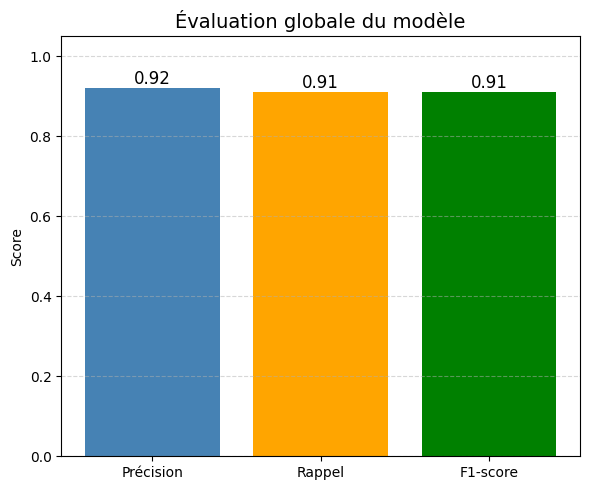

In [7]:
import matplotlib.pyplot as plt

# Valeurs récupérées de l’évaluation
precision = 0.92
recall = 0.91
f1 = 0.91

# Création du graphique
metrics = ['Précision', 'Rappel', 'F1-score']
scores = [precision, recall, f1]

plt.figure(figsize=(6, 5))
bars = plt.bar(metrics, scores, color=["steelblue", "orange", "green"])

# Afficher les valeurs sur les barres
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
             f"{bar.get_height():.2f}", ha='center', fontsize=12)

plt.ylim(0, 1.05)
plt.title("Évaluation globale du modèle", fontsize=14)
plt.ylabel("Score")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [13]:
import spacy
from sklearn.metrics import precision_score, recall_score, f1_score
from unidecode import unidecode

# Charger le modèle entraîné
nlp = spacy.load("model-allergenes")

# Standardiser les labels
def standardiser_label(label):
    label = unidecode(label.strip().lower())
    label = label.replace("_", " ").replace("-", " ")
    label = label.replace("graines de ", "")  # pour éviter les conflits sur sésame
    return label.upper()

# Fonction pour nettoyer les allergènes attendus
def normaliser_allergenes(texte):
    return set([standardiser_label(a) for a in texte.split(",") if a.strip()])

# Stocker les résultats
all_y_true = []
all_y_pred = []



for i, row in test_df.iterrows():
    texte = unidecode(f"{row['Nom du plat']}. {row['Description du plat']}. Ingrédients : {row['Ingrédients']}".lower())
    expected = normaliser_allergenes(row["Allergènes détectés"])
    #  Ignorer les lignes avec 'AUCUN'
    if "AUCUN" in expected:
        continue
    doc = nlp(texte)
    predicted = set([standardiser_label(ent.label_) for ent in doc.ents])

    all_labels = set(list(expected) + list(predicted))
    for label in all_labels:
        all_y_true.append(1 if label in expected else 0)
        all_y_pred.append(1 if label in predicted else 0)

    print(f" Plat : {row['Description du plat']}")
    print(f" Allergènes attendus : {expected}")
    print(f" Allergènes détectés : {predicted}")
    print(f" Vrais positifs : {expected & predicted}")
    print(f" Manqués        : {expected - predicted}")
    print(f"  Faux positifs : {predicted - expected}")
    print("-" * 60)

    # Calcul global
precision = precision_score(all_y_true, all_y_pred)
recall = recall_score(all_y_true, all_y_pred)
f1 = f1_score(all_y_true, all_y_pred)

print("\n Évaluation globale :")
print(f" Précision : {precision:.2f}")
print(f" Rappel    : {recall:.2f}")
print(f" F1-score  : {f1:.2f}")

    


 Plat : pain, chocolat noir, oignons, sesame, oeufs
 Allergènes attendus : {'GLUTEN', 'SESAME', 'OEUFS'}
 Allergènes détectés : {'GLUTEN', 'SESAME', 'OEUFS'}
 Vrais positifs : {'GLUTEN', 'SESAME', 'OEUFS'}
 Manqués        : set()
  Faux positifs : set()
------------------------------------------------------------
 Plat : huile vegetale, pates alimentaires, fromage en grains
 Allergènes attendus : {'GLUTEN', 'LAIT'}
 Allergènes détectés : {'GLUTEN', 'LAIT'}
 Vrais positifs : {'GLUTEN', 'LAIT'}
 Manqués        : set()
  Faux positifs : set()
------------------------------------------------------------
 Plat : lait, huile vegetale, vanille
 Allergènes attendus : {'LAIT'}
 Allergènes détectés : {'LAIT'}
 Vrais positifs : {'LAIT'}
 Manqués        : set()
  Faux positifs : set()
------------------------------------------------------------
 Plat : noisettes, poivrons, oeufs, sauce soja, lait, carottes
 Allergènes attendus : {'SOJA', 'LAIT', 'FRUITS A COQUE', 'OEUFS'}
 Allergènes détectés : {'

In [5]:
import spacy
from spacy.training.example import Example
import json
import random

# Charger les données d'entraînement sauvegardées
with open("train_data.json", "r", encoding="utf-8") as f:
    TRAIN_DATA = json.load(f)

# Initialiser un modèle vierge
nlp = spacy.blank("fr")

# Ajouter le pipeline NER
ner = nlp.add_pipe("ner", last=True)

# Ajouter tous les labels d'entités
for _, annotations in TRAIN_DATA:
    for start, end, label in annotations["entities"]:
        ner.add_label(label)

# Commencer l'entraînement
nlp.initialize()
nlp.begin_training()

for i in range(20):  # nombre d'itérations
    random.shuffle(TRAIN_DATA)
    losses = {}
    for text, annotations in TRAIN_DATA:
        example = Example.from_dict(nlp.make_doc(text), annotations)
        nlp.update([example], losses=losses)
    print(f" Iteration {i+1}, Loss: {losses}")

# Sauvegarder le modèle entraîné
nlp.to_disk("model-allergenes")
print(" Modèle entraîné et sauvegardé dans 'model-allergenes/'")


 Iteration 1, Loss: {'ner': np.float32(1364.3252)}
 Iteration 2, Loss: {'ner': np.float32(196.3924)}
 Iteration 3, Loss: {'ner': np.float32(179.767)}
 Iteration 4, Loss: {'ner': np.float32(125.067505)}
 Iteration 5, Loss: {'ner': np.float32(115.414696)}
 Iteration 6, Loss: {'ner': np.float32(142.07849)}
 Iteration 7, Loss: {'ner': np.float32(58.38072)}
 Iteration 8, Loss: {'ner': np.float32(80.067986)}
 Iteration 9, Loss: {'ner': np.float32(33.80605)}
 Iteration 10, Loss: {'ner': np.float32(44.59229)}
 Iteration 11, Loss: {'ner': np.float32(48.80428)}
 Iteration 12, Loss: {'ner': np.float32(32.585007)}
 Iteration 13, Loss: {'ner': np.float32(40.92234)}
 Iteration 14, Loss: {'ner': np.float32(39.51189)}
 Iteration 15, Loss: {'ner': np.float32(27.687048)}
 Iteration 16, Loss: {'ner': np.float32(52.651363)}
 Iteration 17, Loss: {'ner': np.float32(19.610184)}
 Iteration 18, Loss: {'ner': np.float32(74.70791)}
 Iteration 19, Loss: {'ner': np.float32(26.611782)}
 Iteration 20, Loss: {'ner': 

In [6]:
import re
from sklearn.model_selection import train_test_split
import json
from unidecode import unidecode

# Normalisation du mapping
normalized_mapping = {unidecode(k.lower()): v for k, v in allergen_mapping.items()}

# Fonction de génération du jeu d’entraînement
def create_training_data_from_ingredients(df, allergen_mapping):
    training_data = []
    for _, row in df.iterrows():
        # Texte d’entrée : nom du plat + description + ingrédients
        name = row["Nom du plat"]
        desc = row["Description du plat"]
        ingr = row["Ingrédients"]
        full_text = f"{name}. {desc}. Ingrédients : {ingr}"
        full_text_clean = unidecode(full_text.lower())

        # Ingrédients utilisés pour décider des annotations
        ingredients = unidecode(ingr.lower())
        entities = []
        used_ranges = []

        for word, label in sorted(allergen_mapping.items(), key=lambda x: -len(x[0])):
            if word in ingredients or word in full_text_clean:
                for match in re.finditer(rf"\b{re.escape(word)}\b", full_text_clean):
                    start, end = match.start(), match.end()
                    overlapping = any(start < r[1] and end > r[0] for r in used_ranges)
                    if not overlapping:
                        entities.append((start, end, label))
                        used_ranges.append((start, end))

        if entities:
            training_data.append((full_text_clean, {"entities": entities}))
    return training_data

# Split du dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Générer les annotations uniquement pour le train set
TRAIN_DATA = create_training_data_from_ingredients(train_df, normalized_mapping)

# Sauvegarder dans un fichier json
with open("train_data.json", "w", encoding="utf-8") as f:
    json.dump(TRAIN_DATA, f, ensure_ascii=False, indent=4)

print(f"{len(TRAIN_DATA)} exemples d'entraînement générés et sauvegardés dans train_data.json")


7853 exemples d'entraînement générés et sauvegardés dans train_data.json


In [3]:
allergen_mapping = {
    # Produits laitiers
    "lait": "LAIT", "beurre": "LAIT", "creme": "LAIT", "crème": "LAIT", "fromage": "LAIT", "yaourt": "LAIT",
    "lactose": "LAIT", "mascarpone": "LAIT", "gratin": "LAIT", "parmesan": "LAIT", "béchamel": "LAIT", "creme fraiche": "LAIT",

    # Œufs
    "oeuf": "OEUFS", "oeufs": "OEUFS", "omelette": "OEUFS", "quiche": "OEUFS", "mayonnaise": "OEUFS",
    "flan": "OEUFS", "mousse": "OEUFS", "meringue": "OEUFS",

    # Poisson
    "poisson": "POISSON", "saumon": "POISSON", "thon": "POISSON", "cabillaud": "POISSON", "anchois": "POISSON",
    "lieu": "POISSON", "colin": "POISSON", "morue": "POISSON", "filet de poisson": "POISSON",

    # Crustacés
    "crevette": "CRUSTACES", "crevettes": "CRUSTACES", "crabe": "CRUSTACES", "homard": "CRUSTACES", "langoustine": "CRUSTACES",

    # Mollusques
    "moule": "MOLLUSQUES", "moules": "MOLLUSQUES", "escargot": "MOLLUSQUES", "escargots": "MOLLUSQUES",
    "calamar": "MOLLUSQUES", "seiche": "MOLLUSQUES", "huitre": "MOLLUSQUES",

    # Fruits à coque
    "amande": "FRUITS_A_COQUE", "amandes": "FRUITS_A_COQUE", "noisette": "FRUITS_A_COQUE", "noisettes": "FRUITS_A_COQUE",
    "noix": "FRUITS_A_COQUE", "noix de cajou": "FRUITS_A_COQUE", "pistache": "FRUITS_A_COQUE", "pistaches": "FRUITS_A_COQUE",
    "fruits a coque": "FRUITS_A_COQUE",

    # Arachides
    "arachide": "ARACHIDES", "cacahuete": "ARACHIDES", "cacahuetes": "ARACHIDES",

    # Gluten
    "ble": "GLUTEN", "farine de ble": "GLUTEN", "pain": "GLUTEN", "pate": "GLUTEN", "pates": "GLUTEN",
    "croûtons": "GLUTEN", "semoule": "GLUTEN", "pizza": "GLUTEN", "tarte": "GLUTEN", "couscous": "GLUTEN",
    "pâte brisée": "GLUTEN", "croissant": "GLUTEN", "baguette": "GLUTEN",

    # Soja
    "soja": "SOJA", "sauce soja": "SOJA", "tofu": "SOJA", "miso": "SOJA",

    # Sésame
    "sesame": "SESAME", "graines de sesame": "SESAME", "huile de sesame": "SESAME", "tahin": "SESAME",

    # Céleri
    "celeri": "CELERI", "celeri-rave": "CELERI", "graines de celeri": "CELERI",

    # Moutarde
    "moutarde": "MOUTARDE", "graines de moutarde": "MOUTARDE", "sauce moutarde": "MOUTARDE",

    # Sulfites
    "sulfite": "SULFITES", "sulfites": "SULFITES", "dioxyde de soufre": "SULFITES"
}


In [1]:
#  Étape 1 : Chargement et nettoyage du dataset
import pandas as pd
from unidecode import unidecode

# Charger le fichier CSV original
df = pd.read_csv("data/dataset_menus.csv")

# Nettoyage de base
df = df.dropna(subset=["Description du plat", "Ingrédients"])
df["Ingrédients"] = df["Ingrédients"].str.lower().apply(unidecode)
df["Description du plat"] = df["Description du plat"].str.lower().apply(unidecode)
